In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import networkx as nx
from root_gnn.src.datasets.tauid import TauIdentificationDataset
from tqdm import trange

dataset = TauIdentificationDataset()

2023-03-06 20:34:06.266750: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cray/pe/papi/6.0.0.12/lib64:/opt/cray/job/2.2.4-7.0.3.1_3.33__g36b56f4.ari/lib64:/opt/intel/compilers_and_libraries_2020.2.254/linux/compiler/lib/intel64:/opt/intel/compilers_and_libraries_2020.2.254/linux/mkl/lib/intel64:/global/common/software/nersc/cori-2022q1/sw/darshan/3.4.0/lib
2023-03-06 20:34:06.266779: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/global/cfs/cdirs/m3443/usr/ahuang/het_gnn/envs/gnn/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 

# Utility Functions

In [22]:
ditauPU = '/global/cfs/cdirs/m3443/data/TauStudies/v5/ditau_train.root'
qcdPU = '/global/cfs/cdirs/m3443/data/TauStudies/v5/qcd_train.root'
ditau_test = '/global/cfs/cdirs/m3443/data/TauStudies/v5/ditau_test.root'
qcd_test = '/global/cfs/cdirs/m3443/data/TauStudies/v5/qcd_test.root'
test = '/global/cfs/cdirs/m3443/data/TauStudies/v5/all_test.root'
hlv_names = ["JetLeadingTrackFracP", "JetTrackR", 
             "JetMaxDRInCore", "JetNumISOTracks", "JetTrackMass"]

In [23]:
def get_plotting_param(arr):
    weights = []
    for i in arr:
        weights.append(np.ones_like(i) / len(i))
    rg = [[int(min(i)-0.5), int(max(i)+0.5)] for i in arr]
    #bin_wid = 1
    rg_f = min([i[0] for i in rg]), max([i[1] for i in rg])
    #num_bins = int((rg_f[1]-rg_f[0])/bin_wid)
    return weights, rg_f

In [24]:
def get_data_from_df(df, var):
    var_1p = df.loc[df['signal']==1][var]
    var_3p = df.loc[df['signal']==3][var]
    var_bg = df.loc[df['signal']==0][var]
    if var_1p.dtype == object:
        var_1p = np.array(var_1p)
        var_1p = np.concatenate(var_1p, axis=0)
    if var_3p.dtype == object:
        var_3p = np.array(var_3p)
        var_3p = np.concatenate(var_3p, axis=0)
    if var_bg.dtype == object:
        var_bg = np.array(var_bg)
        var_bg = np.concatenate(var_bg, axis=0)
    return var_1p, var_3p, var_bg

In [6]:
def plot(df, var_name, rg=None, num_bins=25, xlabel="", 
         ylabel='Normalized Frequency', save_name="name.pdf", 
         use_mean=False, font_size=12, loc='best'):
    plt.rcParams['font.size'] = str(font_size)
    var_1p, var_3p, var_bg = get_data_from_df(df, var_name)
    fig, ax = plt.subplots(figsize=(8,8))
    weights, default_rg = get_plotting_param([var_1p, var_3p, var_bg])
    rang = rg if rg is not None else default_rg
    bin_wid = abs(rang[1] - rang[0]) / num_bins
    rang_adj = (rang[0] - bin_wid/2, rang[1] + bin_wid/2)
    num_bins += 1
    ax.hist(var_1p, range=rang_adj, bins=num_bins, weights=weights[0], align='mid', label=r'1-Prong $\tau_{Had}$ Jets', histtype='step', lw=2)
    ax.hist(var_3p, range=rang_adj, bins=num_bins, weights=weights[1], align='mid', label=r'3-Prong $\tau_{Had}$ Jets', histtype='step', lw=2)
    ax.hist(var_bg, range=rang_adj, bins=num_bins, weights=weights[2], align='mid', label='QCD Jets', histtype='step', lw=2)

    if use_mean:
        var_1p_avg = np.mean(var_1p)
        var_3p_avg = np.mean(var_3p)
        var_bg_avg = np.mean(var_bg)
        ax.axvline(var_1p_avg, linestyle='dashed', alpha=0.6, label=r'Mean Value (1-Prong $\tau_{Had}$ Jets)'+f' = {var_1p_avg:.2f}')
        ax.axvline(var_3p_avg, linestyle='dashed', alpha=0.6, color='orange', label=r'Mean Value (3-Prong $\tau_{Had}$ Jets)'+f' = {var_3p_avg:.2f}')
        ax.axvline(var_bg_avg, linestyle='dashed', alpha=0.6, color='green', label=f'Mean Value (QCD Jets) = {var_bg_avg:.2f}')

    #ax.set_title('10,000 Di-Tau and 10,000 QCD Events')
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.legend(loc=loc)

    plt.tight_layout()

    plt.savefig(save_name)
    plt.show()

In [7]:
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    if dphi > np.pi:
        dphi -= 2*np.pi
    if dphi < -np.pi:
        dphi += 2*np.pi
    return dphi

def get_info(chain, sig=False):
    signals = []
    pt, et = [], []
    ntrk, ntwr = [], []
    pt_frac, et_frac = [], []
    hlv = {}
    for name in hlv_names:
        hlv[name] = []
    
    track_idx = 0
    tower_idx = 0
    for ijet in range(chain.nJets):
        
        min_index = 0
        if chain.nTruthJets > 0:
            min_dR = math.sqrt(calc_dphi(chain.JetPhi[ijet],chain.TruthJetPhi[0])**2 + (chain.JetEta[ijet]-chain.TruthJetEta[0])**2)
        for itruth in range(chain.nTruthJets):
            dR = math.sqrt(calc_dphi(chain.JetPhi[ijet],chain.TruthJetPhi[itruth])**2 + (chain.JetEta[ijet]-chain.TruthJetEta[itruth])**2)
            if dR < min_dR:
                min_dR = dR
                min_index = itruth
        if chain.nTruthJets > 0 and min_dR < 0.4:
            isTau = chain.TruthJetIsTautagged[min_index]
        else:
            isTau = 0
        
        tower_Et, track_Pt = [], []
        for itower in range(chain.JetTowerN[ijet]):    
            tower_Et.append(chain.JetTowerEt[tower_idx])
            tower_idx += 1
        
        
        for itrack in range(chain.JetGhostTrackN[ijet]):
            ghost_track_idx = chain.JetGhostTrackIdx[track_idx]
            track_Pt.append(chain.TrackPt[ghost_track_idx])
            track_idx += 1
            
        isTau = 0 if isTau != 1 and isTau != 3 else isTau
        if sig and not isTau:
            continue
        if not sig and isTau:
            continue
        if chain.JetPt[ijet] < 30 or abs(chain.JetEta[ijet]) >= 3:
            continue
        
        track_Pt.sort(reverse=True)
        tower_Et.sort(reverse=True)
        
        signals.append(np.array(isTau, dtype=np.int8))
        pt.append(np.array(track_Pt, dtype=np.float32))
        et.append(np.array(tower_Et, dtype=np.float32))
        ntrk.append(len(track_Pt))
        ntwr.append(len(tower_Et))
        
        # Note: Some jets seem to have 0 total track Pt
        sum_track_pt = sum(track_Pt) if sum(track_Pt) > 0 else 1e-6
        sum_tower_et = sum(tower_Et) if sum(tower_Et) > 0 else 1e-6
        
        pt_frac.append(sum(track_Pt[:10])/sum_track_pt)
        et_frac.append(sum(tower_Et[:6])/sum_tower_et)
        
        for name in hlv:
            hlv[name].append(getattr(chain, name)[ijet])
            
    hlv = pd.DataFrame(hlv)
    llv = pd.DataFrame({'signal':signals, 
                         'pt':pt, 
                         'et':et, 
                         'num_track':ntrk, 
                         'num_tower':ntwr, 
                         'pt_frac':pt_frac, 
                         'et_frac':et_frac})
    return llv, hlv

# Get Info from Root Files

In [8]:
llv_names = ['signal', 'pt', 'et', 'num_track', 'num_tower', 'pt_frac', 'et_frac']
data = {}
for var in llv_names + hlv_names:
    data[var] = []

In [9]:
nevt = 10000
ditau = dataset.read(ditauPU, 0, nevt)
qcd = dataset.read(qcdPU, 0, nevt)

for _ in trange(nevt, desc="ditau"):
    f = next(ditau)
    llv, hlv = get_info(f, sig=True)
    for var in llv_names:
        data[var].extend(llv[var])
    for var in hlv_names:
        data[var].extend(hlv[var])

for _ in trange(nevt, desc="qcd"):
    f = next(qcd)
    llv, hlv = get_info(f, sig=False)
    for var in llv_names:
        data[var].extend(llv[var])
    for var in hlv_names:
        data[var].extend(hlv[var])

df = pd.DataFrame(data)

ditau:   0%|          | 0/10000 [00:00<?, ?it/s]

Welcome to JupyROOT 6.24/06


qcd: 100%|██████████| 10000/10000 [01:06<00:00, 151.04it/s]


# Plots

In [9]:
?plot

Signature:
plot(
    df,
    var_name,
    rg=None,
    num_bins=25,
    xlabel='',
    ylabel='Normalized Frequency',
    save_name='name.pdf',
    use_mean=False,
    font_size=12,
)
Docstring: <no docstring>
File:      /tmp/ipykernel_12688/3183395331.py
Type:      function


## Number of Tracks and Towers per Jet

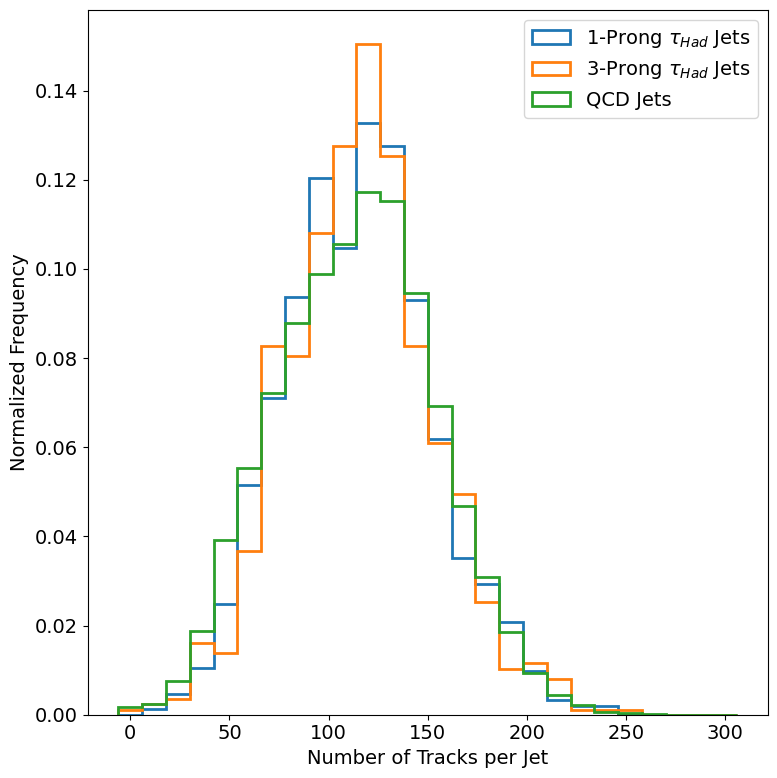

In [24]:
var_name = 'num_track'
plot(df, var_name, rg=(0,300), num_bins=25, 
     xlabel='Number of Tracks per Jet', 
     ylabel=f'Normalized Frequency',
     save_name="LLV_Num_Tracks.pdf",
     use_mean=False, font_size=14)

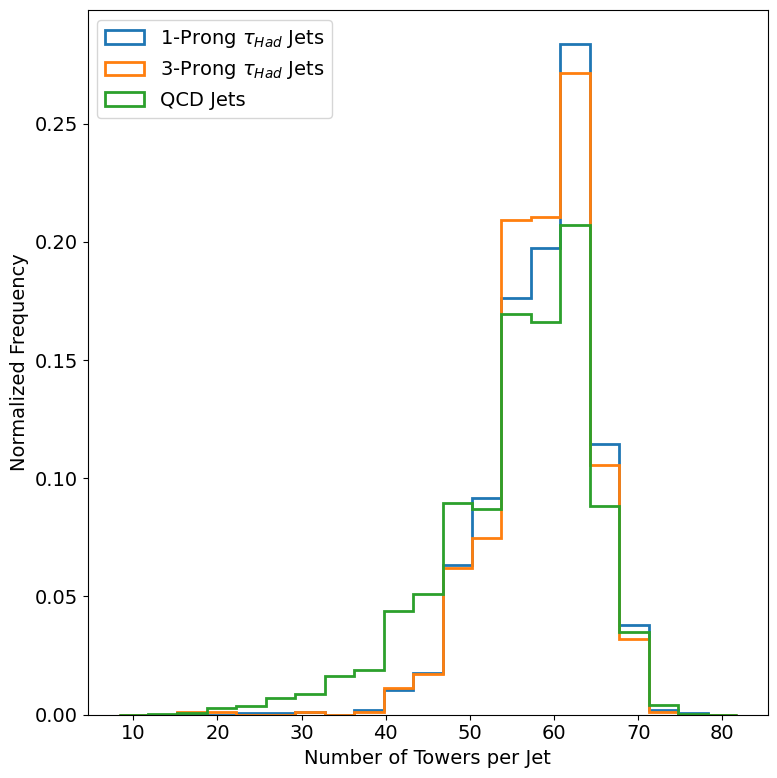

In [25]:
var_name = 'num_tower'
plot(df, var_name, rg=(10,80), num_bins=20, 
     xlabel='Number of Towers per Jet', 
     ylabel=f'Normalized Frequency',
     save_name="LLV_Num_Towers.pdf",
    use_mean=False, font_size=14,loc='upper left')

## Pt and Et of Tracks and Towers

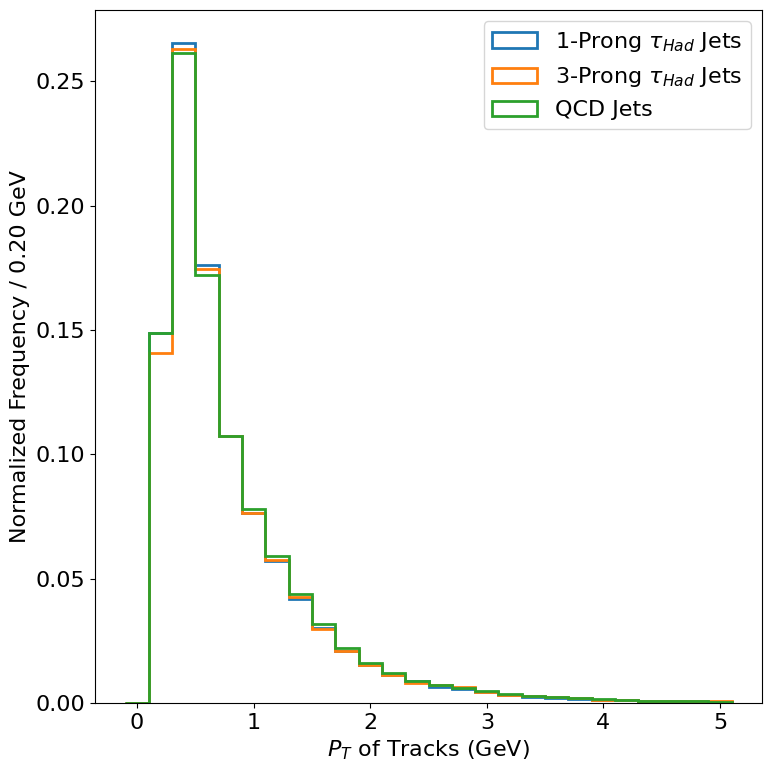

In [26]:
var_name = 'pt'
plot(df, var_name, rg=(0,5), num_bins=25, 
     xlabel=r'$P_T$ of Tracks (GeV)', 
     ylabel=f'Normalized Frequency / {5/25:.2f} GeV',
     save_name="LLV_PT.pdf",
     use_mean=False, font_size=16)

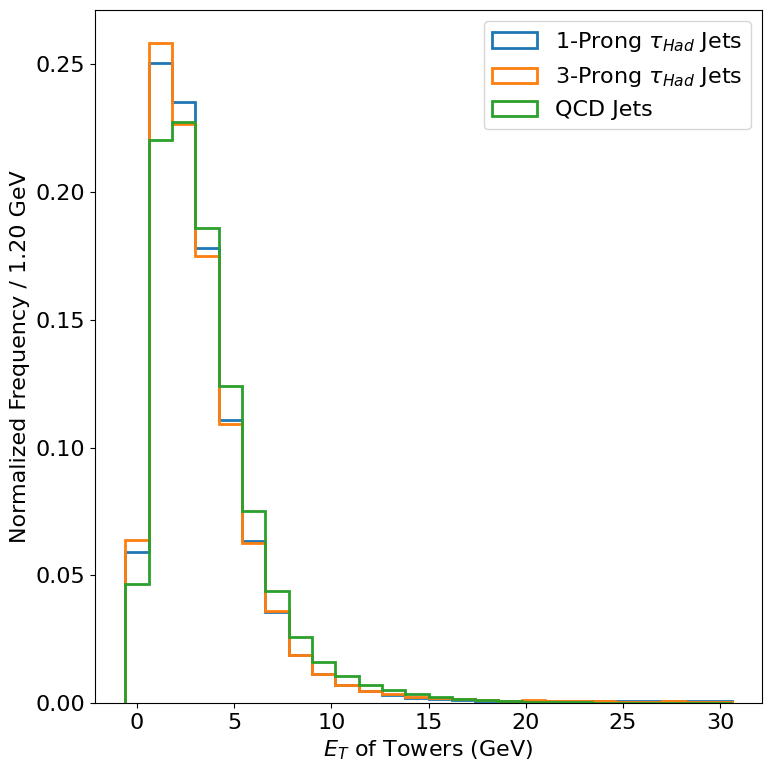

In [27]:
var_name = 'et'
plot(df, var_name, rg=(0,30), num_bins=25, 
     xlabel=r'$E_T$ of Towers (GeV)', 
     ylabel=f'Normalized Frequency / {30/25:.2f} GeV',
     save_name="LLV_ET.pdf",
     use_mean=False, font_size=16)

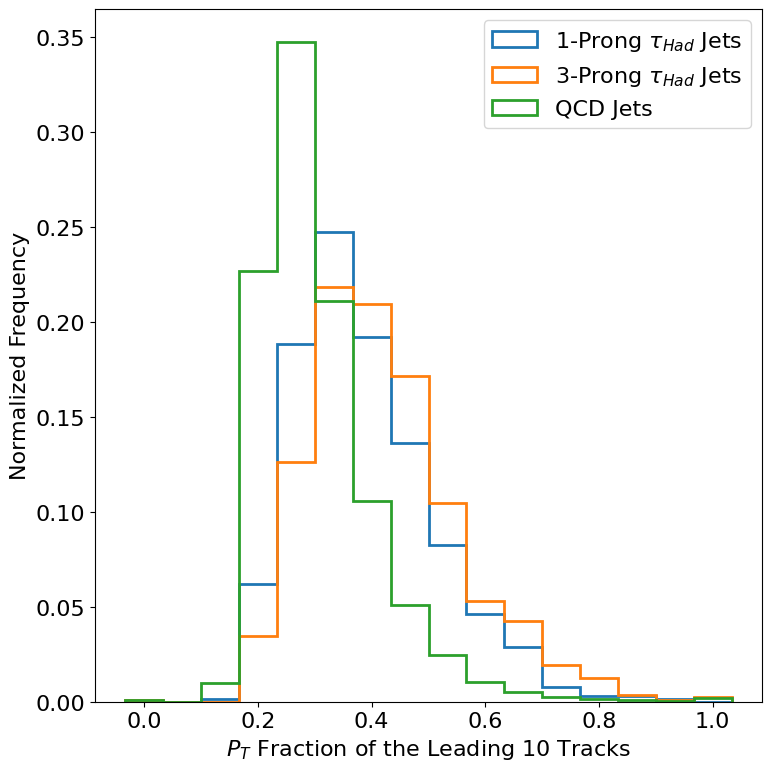

In [28]:
var_name = 'pt_frac'
plot(df, var_name, rg=(0,1), num_bins=15, 
     xlabel=r'$P_T$ Fraction of the Leading 10 Tracks', 
     ylabel=f'Normalized Frequency',
     save_name="LLV_PT_Frac.pdf",
     use_mean=False, font_size=16)

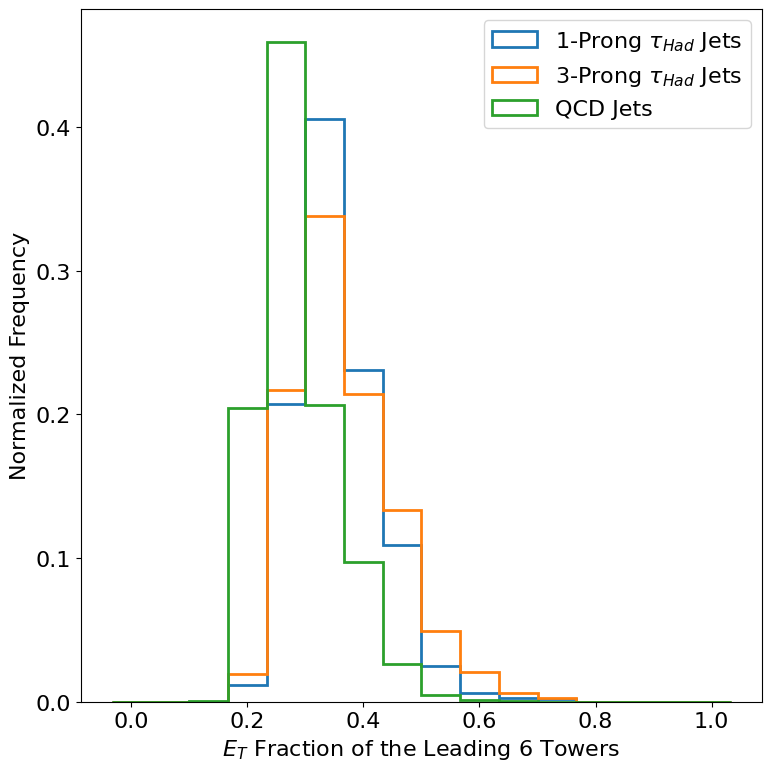

In [29]:
var_name = 'et_frac'
plot(df, var_name, rg=(0,1), num_bins=15, 
     xlabel=r'$E_T$ Fraction of the Leading 6 Towers', 
     ylabel=f'Normalized Frequency',
     save_name="LLV_ET_Frac.pdf",
     use_mean=False, font_size=16)

## High-Level Variables

In [25]:
hlv_labels = ["Leading Track Momentum Fraction", "Track Radius", 
              r"Max Core $\Delta$R", "Number of Tracks in Isolation Region", "Track Mass"]
hlv_rg = [(0,0.5), (0,0.6), (0.1,0.21), (0,80), (0,160)]
hlv_bins = [25, 20, 25, 20, 20]
hlv_fonts = [16, 16, 16, 16, 16]
hlv_locs = ['best', 'upper left', 'upper left', 'best', 'best']

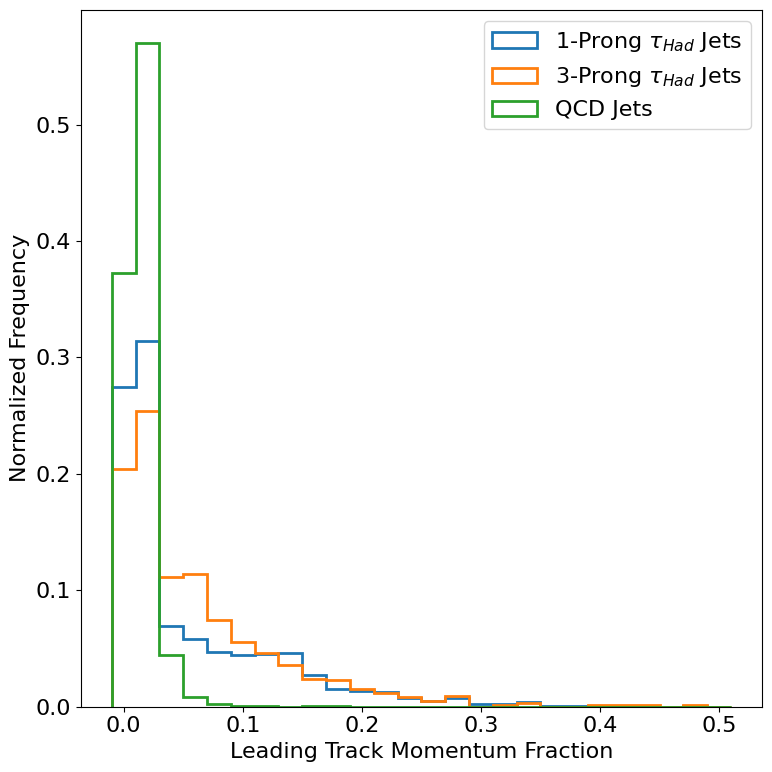

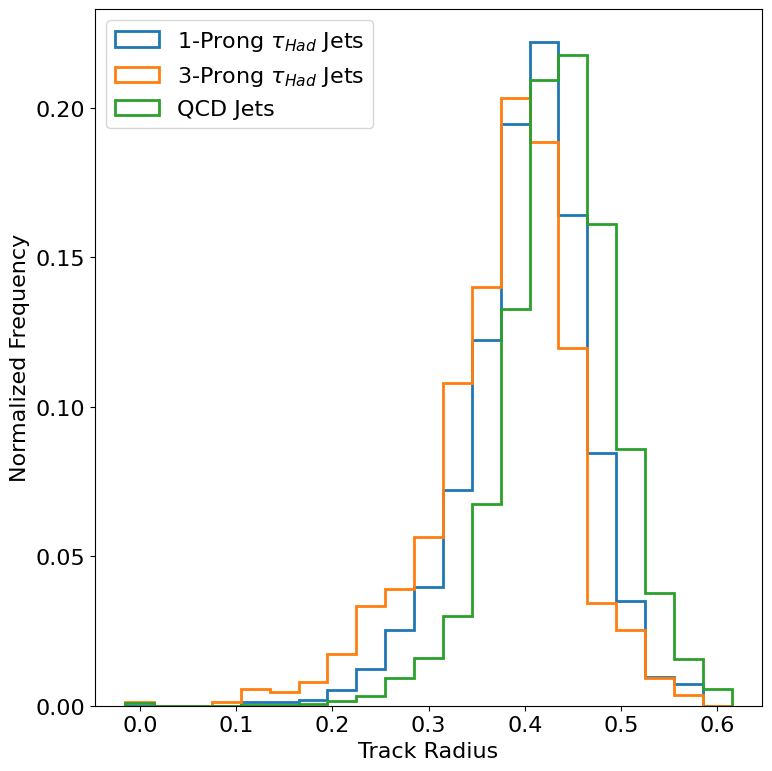

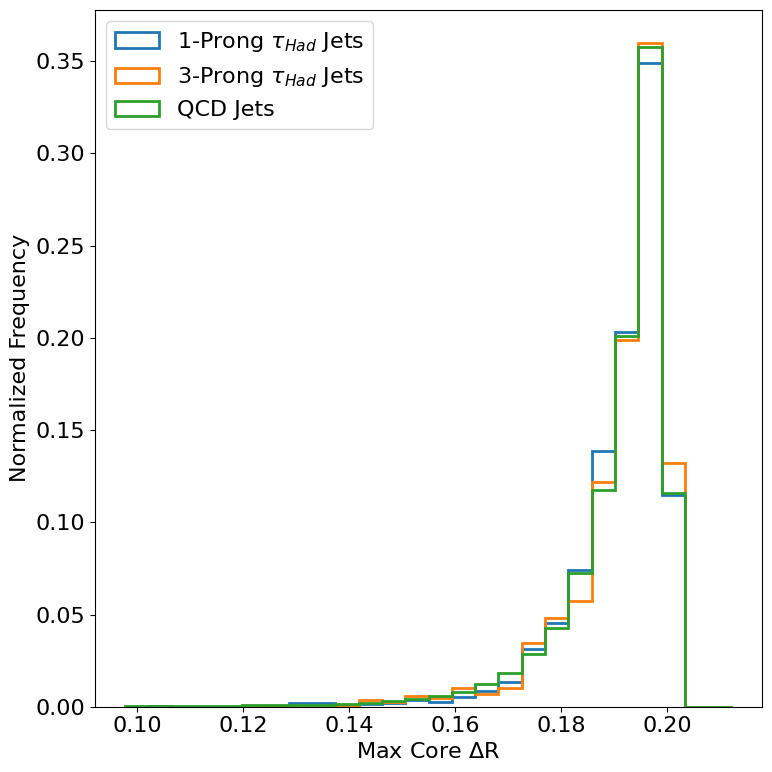

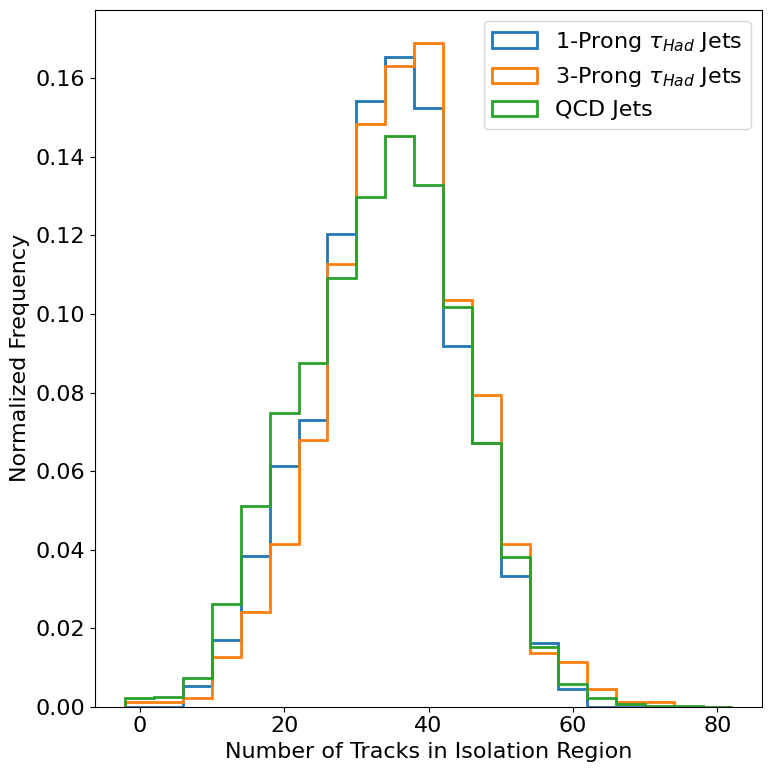

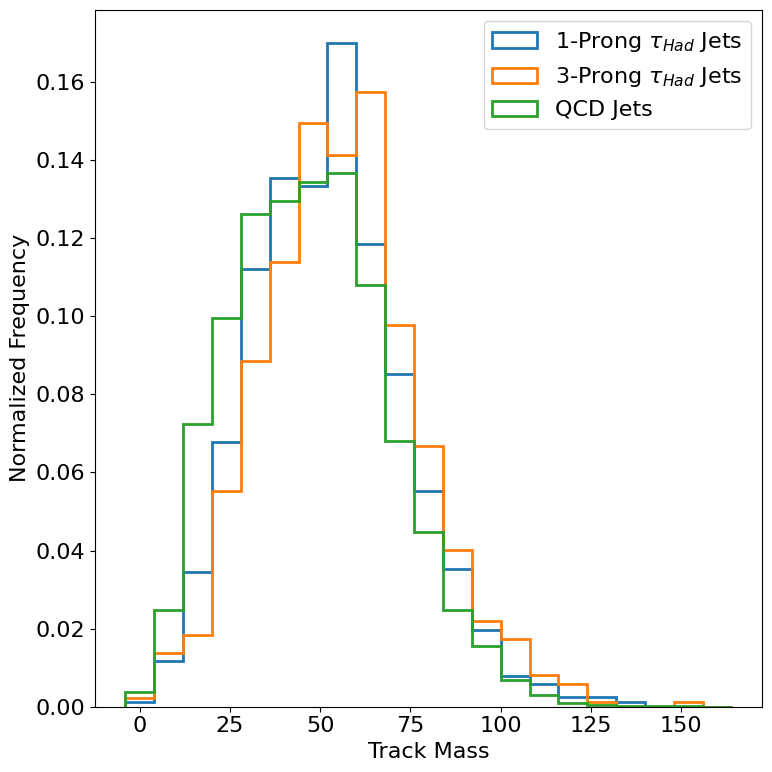

In [26]:
for i in range(len(hlv_names)):
    var_name = hlv_names[i]
    rg = hlv_rg[i]
    label = hlv_labels[i]
    bins = hlv_bins[i]
    font = hlv_fonts[i]
    loc = hlv_locs[i]
    plot(df, var_name, rg=rg, num_bins=bins, 
         xlabel=label, 
         ylabel=f'Normalized Frequency',
         save_name=f"HLV_{label}.pdf",
         use_mean=False, font_size=font, loc=loc)

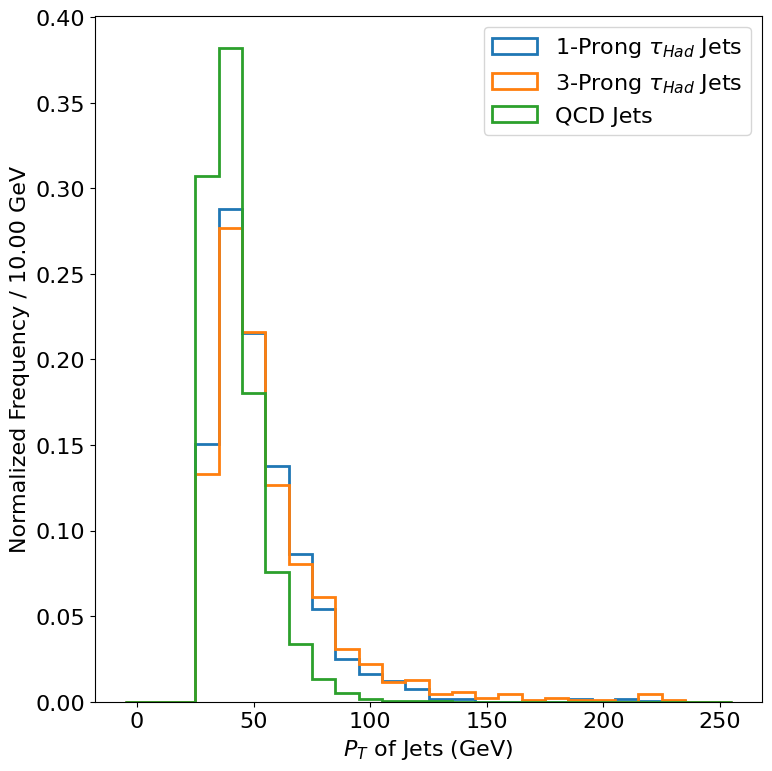

In [19]:
var_name = 'JetPt'
plot(df, var_name, rg=(0,250), num_bins=25, 
     xlabel=r'$P_T$ of Jets (GeV)', 
     ylabel=f'Normalized Frequency / {250/25:.2f} GeV',
     save_name="HLV_JetPT.pdf",
     use_mean=False, font_size=16)